In [2]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pylab as plt
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table,join

import matplotlib.patches as mpatches
from astropy.cosmology import WMAP9
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import matplotlib.patheffects as PathEffects
from astropy import constants
from matplotlib.patches import Rectangle
from matplotlib import colors


In [3]:
FSL_lines  = np.array([('[CI] 610', 492.16065,  'GHz',  609.13537,  'um'),
                       ('[CI] 370', 809.34197,  'GHz',  370.41506,  'um'),
                       ('[NII] 205',1461.13141, 'GHz',  205.17830,  'um'),
                       ('[CII] 158',1900.53690, 'GHz',  157.74093,  'um'),
                       ('[OI] 145', 2060.06886, 'GHz',  145.52545,  'um'),
                       ('[NII] 122',2459.38010, 'GHz',  121.89757,  'um'),
                       ('[OIII] 88',3393.00624, 'GHz',  88.35600,   'um'),
                       ('[OI] 63'  ,4744.77,    'GHz',  63.18,      'um'),
                       ('[NIII] 57',5230.43,    'GHz',  57.32,      'um'),
                       ('[OIII] 52',5786.89659, 'GHz',  51.81450,   'um')],
                    dtype={'names'  :['Line','freq', 'freqUnit', 'wave','waveUnit'],
                           'formats':['|S10','float64','|S10','float64','|S10']})


In [4]:
def line_frequency(line_name):
    '''Given a line name returns the frequency of the line in GHz
    Possible line names include [CI] 610, [CI] 370,[NII] 205, [CII] 158, [OI] 145
    [NII] 122, [OIII] 88, [OI] 63, [OIII] 52'''
    line = np.where(FSL_lines['Line']==line_name)[0][0]
    return FSL_lines['freq'][line]


In [5]:
cloudy_models_fits = fits.open('/Users/qe5106hi/Dropbox/ASTROPHYSICS/cloudymodelforcarl.fits')
cloudy_models = cloudy_models_fits[0].data

cloudy_models_fits.info() #looking into the fits file
cloudy_models_fits[0].header #looking into the headers
#output_folder=

Filename: /Users/qe5106hi/Dropbox/ASTROPHYSICS/cloudymodelforcarl.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       9   (6, 7, 4, 6, 38)   float64   


SIMPLE  =                    T /Primary Header created by MWRFITS v1.11b        
BITPIX  =                  -64 /                                                
NAXIS   =                    5 /                                                
NAXIS1  =                    6 /                                                
NAXIS2  =                    7 /                                                
NAXIS3  =                    4 /                                                
NAXIS4  =                    6 /                                                
NAXIS5  =                   38 /                                                
EXTEND  =                    T /Extensions may be present                       

In [6]:
data_location='/Users/qe5106hi/Dropbox/ASTROPHYSICS/oiii_nii_ff_metallicity.csv'
data_table = ascii.read(data_location,data_start=2) #Takes the data from second Row. To avoid the Metadata we 

In [7]:
for column in data_table.columns[2,3,5,6,8,9,11,12,14,15,17,18,20,21]:
    data_table['%s' %column].unit = '1e-18 W m^-2' 
for column in data_table.columns[24,25]:
    data_table['%s' %column].unit='12+log(O/H)'
for column in data_table.columns[27,28,32,33]:
    data_table['%s' %column].unit='mJy'
for column in data_table.columns[30,34]:
    data_table['%s' %column].unit='GHz'
data_table.columns[30,34].unit = 'GHz'
data_table.columns[37].unit = 'Mpc'

In [8]:
def make_masked_quantities(data_table,convert_unit=False,desired_unit=None):
    #print unit
    if convert_unit == False:
        values = (data_table.data.data.astype(np.float)*data_table.unit)
    else:
        values = (data_table.data.data.astype(np.float)*data_table.unit).to(desired_unit)
    mask = data_table.mask
    return ma.array(values,mask=mask)

In [9]:
def linear_to_log_errors(data_table,linear_errors): #Function to return the error
    upper_bound = data_table+linear_errors #bound 1st(log,error,direction)
    lower_bound = data_table-linear_errors #bound 1st(log,error,direction)
    log_data = np.log10(data_table)#take_log 1st
    log_upper_bound = np.log10(upper_bound) #take_log 2nd
    log_lower_bound = np.log10(lower_bound) #take_log 3rd
    positive_error = log_upper_bound-log_data #bound 2nd(log,error,direction)
    negative_error = log_data-log_lower_bound #bound 2nd(log,error,direction)
    return positive_error,negative_error
    
def linear_to_log_errors_log_data(log_data_table,linear_errors):
    upper_bound = 10**log_data_table+linear_errors
    lower_bound = 10**log_data_table-linear_errors
    log_data = log_data_table
    log_upper_bound = np.log10(upper_bound)
    log_lower_bound = np.log10(lower_bound)
    positive_error = log_upper_bound-log_data
    negative_error = log_data-log_lower_bound
    return positive_error,negative_error

In [10]:
#cii = make_masked_quantities(data_table['CII'],True,'W m^-2')
cii_data = make_masked_quantities(data_table['CII'],True,'W m^-2')
ERRcii = make_masked_quantities(data_table['errCII'],True,'W m^-2')
ULcii = np.zeros(len(cii_data))
ULcii[np.where(data_table['ulCII']==1)[0]]= True ##??


#nii = make_masked_quantities(data_table['N122'],True,'W m^-2')
nii_data = make_masked_quantities(data_table['N122'],True,'W m^-2')
nii_data = make_masked_quantities(data_table['N122'],True,'W m^-2')
ERRnii = make_masked_quantities(data_table['errN122'],True,'W m^-2')
ULnii = np.zeros(len(nii_data))
ULnii[np.where(data_table['ulN122']==1)[0]]=True

#oiii= make_masked_quantities(data_table['OIII88'],True,'W m^-2')
oiii_data= make_masked_quantities(data_table['OIII88'],True,'W m^-2')
ERRoiii = make_masked_quantities(data_table['errOIII88'],True,'W m^-2')
ULoiii = np.zeros(len(oiii_data))
ULoiii[np.where(data_table['ulOIII88']==1)[0]]=True #?????????

ff  = make_masked_quantities(data_table['FreeFree'])
ERRff = make_masked_quantities(data_table['errFreeFree'])
#For Free Free values without an uncertainty I assume an error 30% (i.e they are ~3 sigma detections)
ERRff[np.where(data_table['errFreeFree'].data.data==0.)[0]]=0.3*ff[np.where(data_table['errFreeFree'].data.data==0.)[0]].data
ULff = np.zeros(len(ff))
ULff[np.where(data_table['ulFreeFree']==1)[0]]=True

metallicity = ma.array(np.copy(data_table['Metallicity'].data.data),mask=data_table['Metallicity'].data.mask)
ERRmetallicity = data_table['errMetallicity'].data.data
#For the metallicity values without a given uncertainty I give a 0.1 dex error
ERRmetallicity[np.where(data_table['errMetallicity'].data.data<0.1)[0]]=0.1

cloudy_o_solar_abundance = 8.69
cloudy_n_solar_abundance = 7.93
#abundance = metallicity - cloudy_o_solar_abundance
abundance_data = metallicity - cloudy_o_solar_abundance

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:24: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


In [11]:
np.shape(nii_data)

(36,)

In [12]:
sed = np.concatenate([cloudy_models[23:27,:,:,:,:],cloudy_models[37:30:-1,:,:,:,:]],axis=0) #SED Stands For?
wavelength = [0.0083,0.0025,0.0060,0.0100,0.6917,0.9993,1.335,2.003,3.432,6.137,20.46]
frequency = 3e10/np.array(wavelength)

In [13]:
markers=['o','s','^','*','d','x']
colors = ['m','y','c','r','b','g','grey']
linestyles = ['-','--',':','-.','-','--',':']

In [14]:
lines_IR = cloudy_models[4:12,:,:,:,:] #Taking 4:12 for first dimension and everything for rest?
lines_IR_names = ['[CII] 158', '[OI] 63', '[OI] 145', '[NII] 122', '[NII] 205', '[NIII] 57', '[OIII] 88', '[NII] 52' ]
line_wavelength = [157.6,63.17,145.5,121.7,205.4,57.21,88.33,51.80] #microns
#frequency = 3e10/np.array(wavelength)

hbeta = cloudy_models[13,:,:,:,:]
hbeta_wavelength = 0.4861 #microns

nii_205 = lines_IR[4,:,:,:,:]
nii = lines_IR[3,:,:,:,:]
oiii = lines_IR[6,:,:,:,:]
cii = lines_IR[0,:,:,:,:]
Snu_5ghz = sed[9,:,:,:,:]
Snu_8ghz = sed[8,:,:,:,:]
abundances = cloudy_models[1,0,:,0,0]
stellar_age = cloudy_models[2,:,0,0,0]
densities = cloudy_models[0,0,0,0,:]
ionization_param = cloudy_models[3,0,0,:,0]
nii_5GHz = nii/Snu_5ghz
oiii_5GHz = oiii/Snu_5ghz
cii_5GHz = cii/Snu_5ghz
nii_205_5GHz = nii_205/Snu_5ghz

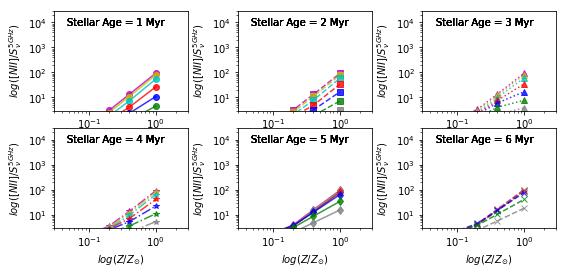

In [18]:
#plot models for all ages, metalicities, ionization
dens = 5
fig = plt.figure(1,figsize=(9,4))
fig.subplots_adjust(hspace=.175,wspace=.375)
for age in np.arange(len(stellar_age)):
    figure_number = age +1
    ax1 = plt.subplot(2,3,figure_number)
    ax1.set_ylabel(r'$log([NII]/S_{\nu}^{5 GHz})$')
    ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
    plt.xlim(3e-2,3e0)
    plt.ylim(3e0,3e4)
    for ionization in np.arange(len(ionization_param)):
        ax1.loglog(abundances,nii_5GHz[age,:,ionization,dens],marker=markers[age],
                   linestyle=linestyles[age],alpha=0.8,color=colors[ionization])
        ax1.annotate("Stellar Age = %i Myr" %stellar_age[age],(0.1,0.85),xycoords='axes fraction')
plt.savefig("cloudy_nii_5ghz_hden%f.png")
plt.show()

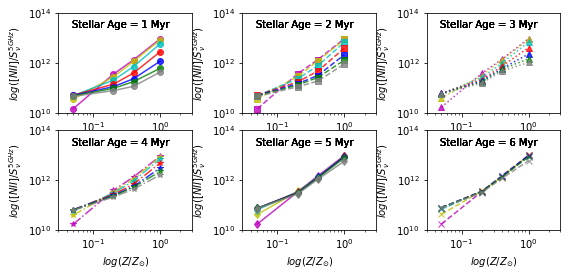

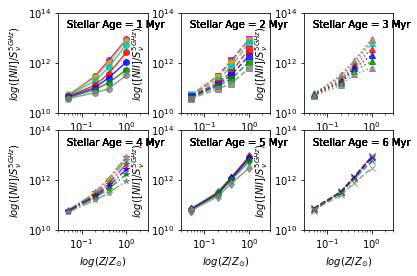

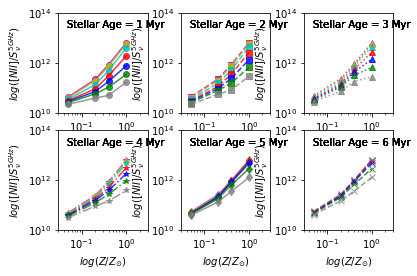

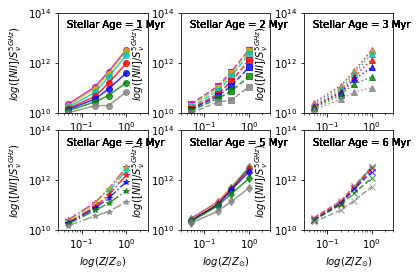

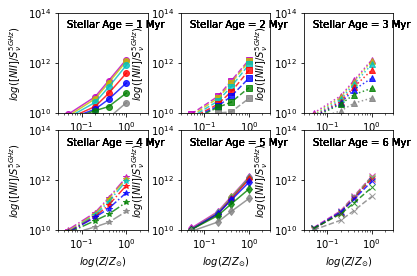

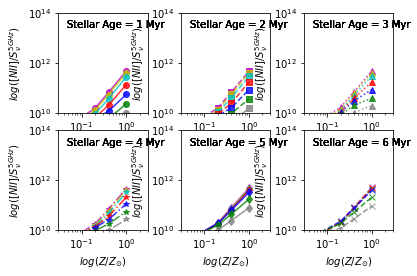

In [19]:
for dens in np.arange(len(densities)):
    fig = plt.figure(1,figsize=(9,4))
    fig.clf() #clears the current figure
    fig.subplots_adjust(hspace=.175,wspace=.375)
    for age in np.arange(len(stellar_age)):
        figure_number = age +1
        ax1 = plt.subplot(2,3,figure_number)
        ax1.set_ylabel(r'$log([NII]/S_{\nu}^{5 GHz})$')
        ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
        plt.xlim(3e-2,3e0)
        plt.ylim(1e10,1e14)
        for ionization in np.arange(len(ionization_param)):
            ax1.loglog(abundances,nii_5GHz[age,:,ionization,dens]*frequency[9],marker=markers[age],
                       linestyle=linestyles[age],alpha=0.8,color=colors[ionization])
            ax1.annotate("Stellar Age = %i Myr" %stellar_age[age],(0.1,0.85),xycoords='axes fraction')
    plt.show()
    plt.savefig('cloudy_nii_5ghz_HertzUNITS_hden%f.png' %densities[dens],dpi=300,bbox_inches='tight',pad_inches=0.5)
    

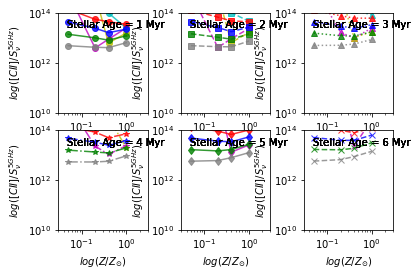

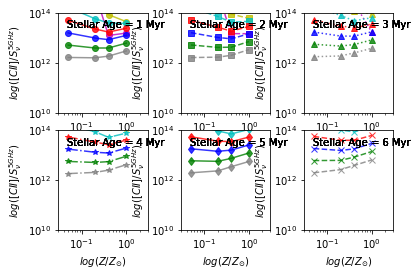

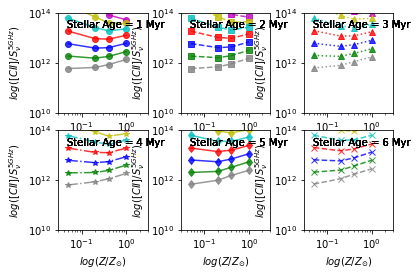

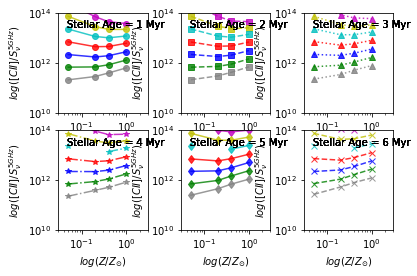

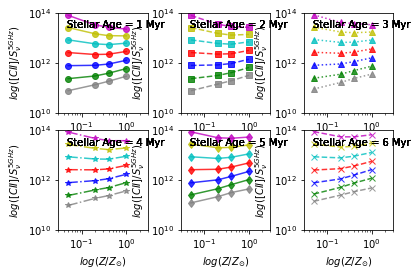

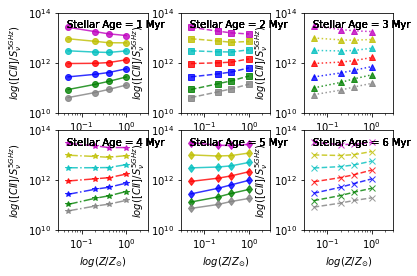

In [17]:
for dens in np.arange(len(densities)):
    fig = plt.figure(1,figsize=(9,4))
    fig.clf() #clears the current figure
    fig.subplots_adjust(hspace=.175,wspace=.375)
    for age in np.arange(len(stellar_age)):
        figure_number = age +1
        ax1 = plt.subplot(2,3,figure_number)
        ax1.set_ylabel(r'$log([CII]/S_{\nu}^{5 GHz})$')
        ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
        plt.xlim(3e-2,3e0)
        plt.ylim(1e10,1e14)
        for ionization in np.arange(len(ionization_param)):
            ax1.loglog(abundances,cii_5GHz[age,:,ionization,dens]*frequency[9],marker=markers[age],
                       linestyle=linestyles[age],alpha=0.8,color=colors[ionization])
            ax1.annotate("Stellar Age = %i Myr" %stellar_age[age],(0.1,0.85),xycoords='axes fraction')
    
    plt.savefig('cloudy_cii_5ghz_HertzUNITS_hden%f.png' %densities[dens],dpi=300,bbox_inches='tight',pad_inches=0.5)
    plt.show()
    

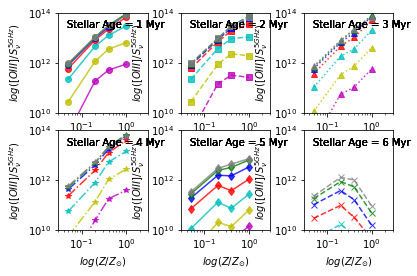

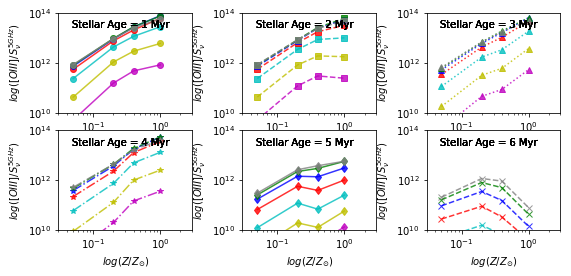

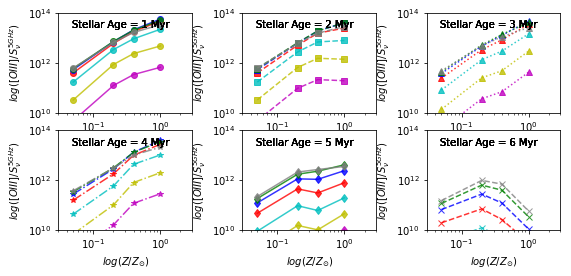

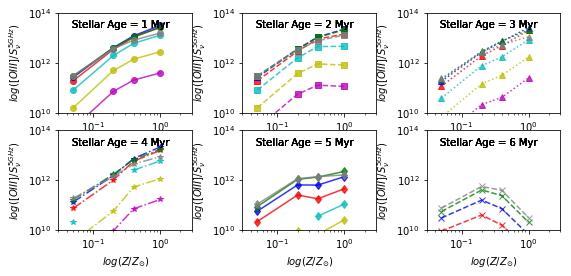

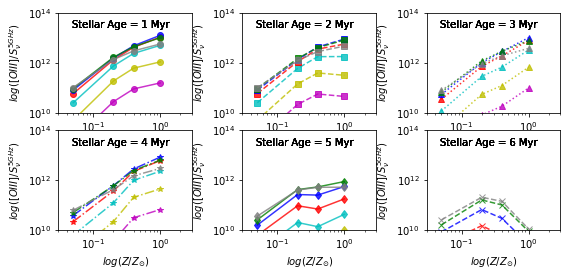

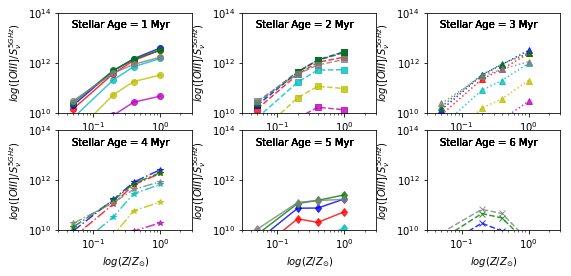

In [18]:
for dens in np.arange(len(densities)):
    fig = plt.figure(1,figsize=(9,4))
    fig.clf() #clears the current figure
    fig.subplots_adjust(hspace=.175,wspace=.375)
    for age in np.arange(len(stellar_age)):
        figure_number = age +1
        ax1 = plt.subplot(2,3,figure_number)
        ax1.set_ylabel(r'$log([OIII]/S_{\nu}^{5 GHz})$')
        ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
        plt.xlim(3e-2,3e0)
        plt.ylim(1e10,1e14)
        for ionization in np.arange(len(ionization_param)):
            ax1.loglog(abundances,oiii_5GHz[age,:,ionization,dens]*frequency[9],marker=markers[age],
                       linestyle=linestyles[age],alpha=0.8,color=colors[ionization])
            ax1.annotate("Stellar Age = %i Myr" %stellar_age[age],(0.1,0.85),xycoords='axes fraction')
    
    plt.savefig('cloudy_oiii_5ghz_HertzUNITS_hden%f.png' %densities[dens],dpi=300,bbox_inches='tight',pad_inches=0.5)
    plt.show()
    

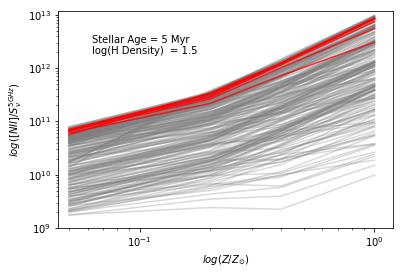

In [51]:
#Single Plot of All Models
###################
#Divide by the frequency of the continuum points to have the line to ratio in the observal units of [Hz]              
###################
fig = plt.figure(1,figsize=(6,4))
fig.clf()
ax1 = plt.subplot(111)
ax1.set_ylabel(r'$log([NII]/S_{\nu}^{5 GHz})$')
ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
plt.xlim(4.5e-2,1.2e0)
plt.ylim(1e9,1.2e13)

key_dens = 1 #
key_age = 4 #5 mega year
ax1.annotate("Stellar Age = %i Myr" %stellar_age[key_age],(0.1,0.85),xycoords='axes fraction')
ax1.annotate(r"log(H Density)  = %.1f" %densities[key_dens],(0.1,0.80),xycoords='axes fraction')
for dens in np.array([0,2,3,4,5,1]):
    for age in np.array([0,1,2,3,5,4]):
        for ionization in np.arange(len(ionization_param)):
            if dens == key_dens and age == key_age:
                line_color = 'red'
                alphas = 0.8
            else:
                line_color = 'grey'
                alphas = 0.3
            ax1.loglog(abundances,nii_5GHz[age,:,ionization,dens]*frequency[9],marker=None,
                       linestyle='-',alpha=alphas,color=line_color)

    
plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


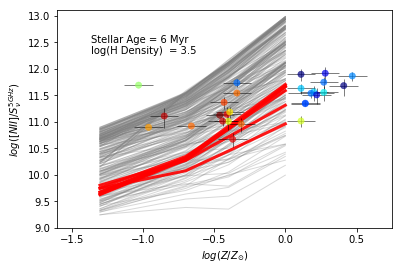

In [52]:
#Plot all models and over plot the observed data              
###################
for key_dens in np.arange(len(densities)):
    for key_age in np.arange(len(stellar_age)):
        #print key_dens, key_age
        fig = plt.figure(1,figsize=(6,4))
        fig.clf()
        ax1 = plt.subplot(111)
        ax1.set_ylabel(r'$log([NII]/S_{\nu}^{5 GHz})$')
        ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
        plt.xlim(-1.6,0.75)
        plt.ylim(9.0,13.1)
        #key_dens = 3 #
        #key_age = 2 #5 mega year
        ax1.annotate("Stellar Age = %i Myr" %stellar_age[key_age],(0.1,0.85),xycoords='axes fraction')
        ax1.annotate(r"log(H Density)  = %.1f" %densities[key_dens],(0.1,0.80),xycoords='axes fraction')
        for dens in  np.arange(len(densities)):
            for age in np.arange(len(stellar_age)):
                for ionization in np.arange(len(ionization_param)):
                    if dens == key_dens and age == key_age:
                        line_color = 'red'
                        alphas = 0.9
                        zorder = -5
                        linewidths = 3
                    else:
                        line_color = 'grey'
                        alphas = 0.3
                        zorder = -10
                        linewidths = 1
                    ax1.plot(np.log10(abundances),np.log10(nii_5GHz[age,:,ionization,dens]*frequency[9]),marker=None,
                               linestyle='-',alpha=alphas,color=line_color,zorder=-10,linewidth=linewidths)
        
        #plot the read data    
        ydata = ma.array(np.log10((nii_data/ff).data.value*10.0**29),mask=(nii_data/ff).mask)
        xdata = abundance_data
        zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=(oiii_data/nii_data).mask)
        
        #cmap = plt.cm.jet
        #norm = colors.Normalize(zdata.min(),zdata.max())
        #ec_colors = plt.cm.jet(norm(zdata))
        
        
        yerr_linear = np.sqrt((ERRnii/nii_data).data.value**2+(ERRff/ff).data.value**2)*(nii_data/ff).data.value*10.0**29
        yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
        yerr_log_pos.mask = ydata.mask
        yerr_log_neg.mask = ydata.mask
        yuplims = ULnii
        
        yerr=np.vstack([yerr_log_neg,yerr_log_pos])
        yerr.mask=yuplims
        xerr = ERRmetallicity
        
        ax1.scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
        ax1.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,lolims=yuplims,
                     ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:61: RuntimeWarning: divide by zero encountered in log10


NameError: name 'key_dens' is not defined

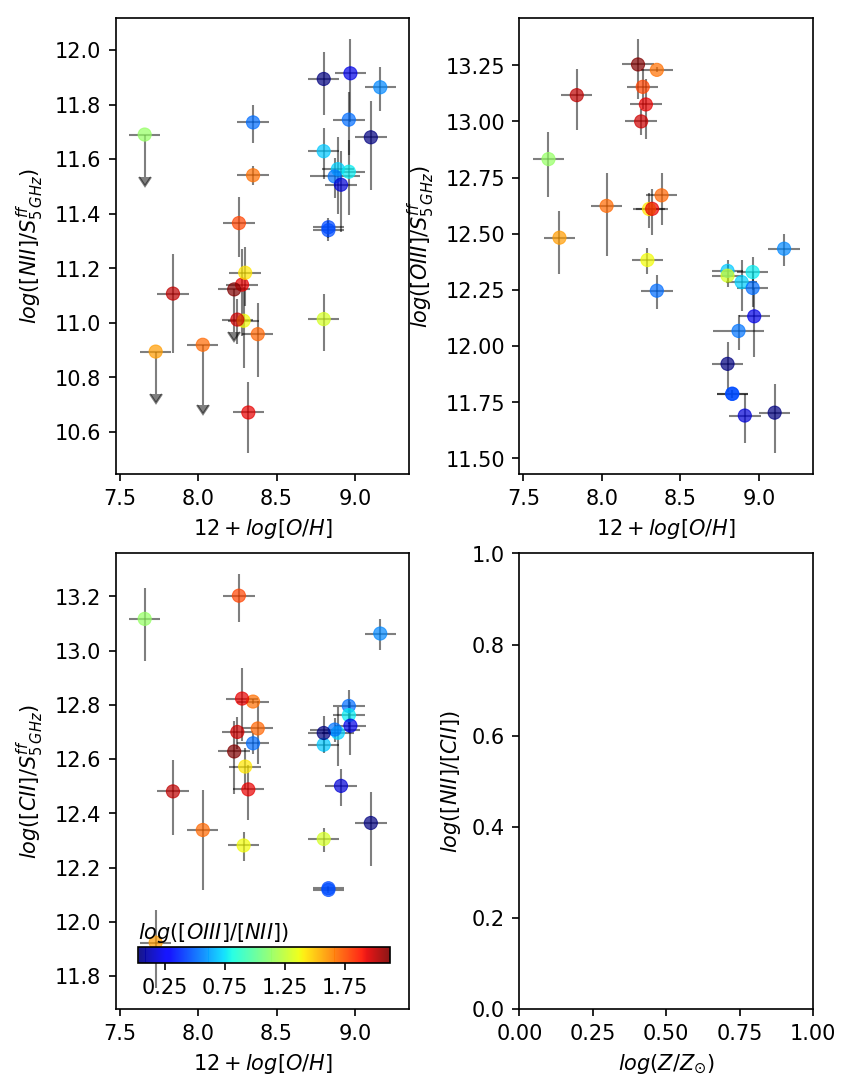

In [15]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(6,8.75),dpi=150)
fig.subplots_adjust(hspace=.175,wspace=.375)

#----------------NII/FF versus Metalicity ------------------------------------#
axes[0,0].set_ylabel(r'$log([NII]/S_{5\: GHz}^{ff})$')
axes[0,0].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((nii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

#cmap = plt.cm.jet
#norm = colors.Normalize(zdata.min(),zdata.max())
#ec_colors = plt.cm.jet(norm(zdata))


yerr_linear = np.sqrt((ERRnii/nii_data).data.value**2+(ERRff/ff).data.value**2)*(nii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yuplims = ULnii
#yerr_log_pos.mask = yuplims
#yerr_log_neg.mask = yuplims
where_UL=np.where(yuplims==1.0)[0]
yerr_log_pos[where_UL]=0

yerr=np.vstack([yerr_log_neg,yerr_log_pos])
#yerr.mask=yuplims
xerr = ERRmetallicity

axes[0,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0,0].errorbar(xdata,ydata,xerr=xerr,yerr=yerr,uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)


#----------------OIII/FF versus Metalicity ------------------------------------#

axes[0,1].set_ylabel(r'$log([OIII]/S_{5\: GHz}^{ff})$')
axes[0,1].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((oiii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRoiii/oiii_data).data.value**2+(ERRff/ff).data.value**2)*(oiii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULoiii

xerr = ERRmetallicity

axes[0,1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0,1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims, #??????????????????????
ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)
             


#----------------CII/FF versus Metalicity ------------------------------------#
axes[1,0].set_ylabel(r'$log([CII]/S_{5\: GHz}^{ff})$')
axes[1,0].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((cii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity
zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=ma.copy((oiii_data/nii_data).mask))

yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULcii

xerr = ERRmetallicity

cii_plot=axes[1,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
cii_error=axes[1,0].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],uplims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt='none',zorder=-1.0,alpha=0.5)
             


#cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
#                  anchor)
CBposition=fig.add_axes([0.15,0.16,0.28,0.0125])
cb = fig.colorbar(cii_plot,cax=CBposition, ticks=[0.25,.75,1.25,1.75,2.25],orientation="horizontal")
cbax = cb.ax
cbax.text(0.0,1.5,r'$log([OIII]/[NII])$',horizontalalignment='left')
#cb.set_label(r'$[OIII]/[NII]$')


  

  
axes[1,1].set_ylabel(r'$log([NII]/[CII])$')
axes[1,1].set_xlabel(r'$log(Z/Z_{\odot})$')
#Models        
for dens in  np.arange(len(densities)):
    for age in np.arange(len(stellar_age)):
        for ionization in np.arange(len(ionization_param)):
            if dens == key_dens and age == key_age:
                line_color = IP_colors[ionization]
                alphas = key_alpha
                zorders = key_zorder
                linewidths = key_lindwidths
                labels= "%.1f" %ionization_param[ionization]
            else:
                line_color = else_color
                alphas = else_alpha
                zorders = else_zorder
                linewidths = else_linewidth
                labels=None
            axes[1,1].plot(np.log10(abundances),np.log10(nii[age,:,ionization,dens]/cii[age,:,ionization,dens]),marker=None,
                        linestyle='-',alpha=alphas,color=line_color,zorder=zorders,linewidth=linewidths,label=labels)
#Data
ydata = ma.array(ma.log10((nii_data/cii_data).data.value),mask=(nii_data/cii_data).mask)
xdata = abundance_data
zdata = ma.array(ma.log10((oiii_data/nii_data).data.value),mask=(oiii_data/nii_data).mask)
        
yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRnii/nii_data).data.value**2)*(nii_data/cii_data).data.value
yuplims = ULnii
        #yerr_log_pos.mask = yuplims
        #yerr_log_neg.mask = yuplims
where_UL=np.where(yuplims==1.0)[0]
yerr_linear[where_UL]=(nii_data/cii_data).data.value[where_UL]*0.3
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)

yerr_log_pos[where_UL]=0
        

        #yerr=np.vstack([yerr_log_neg,yerr_log_pos])
        #yerr.mask=yuplims
        #xerr = ERRmetallicity
        
axes[1,1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[1,1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,
                ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
             
        
        
#-----------------------------------------------------------------------------#
#adjust the ticks and spaceing
for ax in axes.flat:
    ax.set_ylim([10.5,13.5])
    ax.set_xlim([7.5,9.5])
    ax.set_yticks([10.5,11,11.5,12.0,12.5,13.0,13.5])
    ax.set_xticks([8.0,8.5,9.0,9.5])
    ax.grid(True,alpha=0.3)


        
axes[1,1].set_ylim([-3.0,0.0])
axes[1,1].set_xlim([-1.25,0.75])
axes[1,1].set_yticks([-3.0,-2.5,-2,-1.5,-1,-0.5,0])
axes[1,1].set_xticks([-1.0,-0.5,0.0,0.5])
    
#plt.show()

In [32]:
def gauss2D(x,y,x0,y0,ex,ey):
    z = np.exp(-((x-x0)**2/(2*ex**2)+(y-y0)**2/(2*ey**2)))
    return z

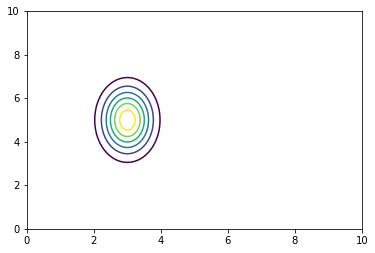

In [53]:
x0=3.
y0=5.

ex=.5
ey=1.

xval = np.arange(0,10,.01)
yval = np.arange(0,10,.01)

xx, yy = np.meshgrid(xval,yval)

plt.figure(1)
plt.contour(xval,yval,gauss2D(xx,yy,x0,y0,ex,ey))
#plt.imshow(gauss2D(xx,yy,x0,y0,ex,ey))

/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


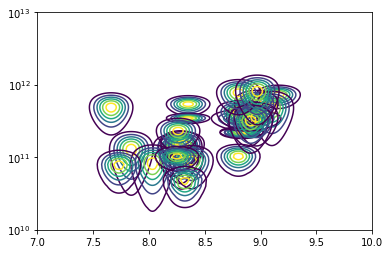

In [73]:
#try can make gaussians for each galaxy
ydata = ma.array(((nii_data/ff).data.value*10.0**29),mask=ma.copy((nii_data/ff).mask))
xdata = metallicity

yerr_linear = np.sqrt((ERRnii/nii_data).data.value**2+(ERRff/ff).data.value**2)*(nii_data/ff).data.value*10.0**29
#yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
#yuplims = ULnii
#yerr_log_pos.mask = yuplims
#yerr_log_neg.mask = yuplims
#where_UL=np.where(yuplims==1.0)[0]
#yerr_log_pos[where_UL]=0

#yerr=np.vstack([yerr_log_neg,yerr_log_pos])
#yerr.mask=yuplims
yerr = yerr_linear
xerr = ERRmetallicity

ygrid = np.linspace(10**10.0, 10**13, 1000)
xgrid = np.linspace(7.0,10.,1000)
xx,yy = np.meshgrid(xgrid,ygrid)

plt.figure(2)
n=0
gaussian_grid=np.array([])
for galaxy in xdata:
    plt.contour(xgrid,ygrid,gauss2D(xx,yy,xdata[n],ydata[n],xerr[n],yerr[n]))
    if n == 0:
        gaussian_grid=gauss2D(xx,yy,xdata[n],ydata[n],xerr[n],yerr[n])
    else:
        gaussian_grid=np.dstack([gaussian_grid,gauss2D(xx,yy,xdata[n],ydata[n],xerr[n],yerr[n])])
    n=n+1
plt.yscale('symlog')

In [70]:
np.min(ydata)

46923076923.076912

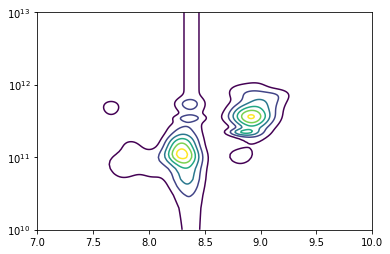

In [80]:
plt.contour(xx,yy,np.sum(gaussian_grid,axis=2))
plt.yscale('symlog')

In [65]:
yerr[0]

masked_array(data = [ 0.08726741        -inf  0.16457441  0.03870608  0.03837326        -inf
        -inf        -inf  0.08059206        -inf  0.19212913        -inf
  0.10324953  0.11735213        -inf  0.17195676  0.13102211  0.15956589
  0.17430717        -inf  0.0741904   0.13095934  0.17887728  0.03659531
  0.18728086  0.15490196  0.12185596  0.21682895  0.22184875  0.15644484
  0.12566915  0.08979549        -inf  0.14866049  0.15490196  0.15490196],
             mask = False,
       fill_value = 1e+20)

In [1]:
def linear_model(m,x,b):
    y = m*x +b
    return y

mlist = np.linspace(-10**14,10**14,10)  #Get intercept too and fit a
                                        #linear model for each galaxy ..numerous models for each galaxies

blist = np.linspace(-10**14,10**14,10)

ygrid = np.linspace(10**10.0, 10**13, 1000)
xgrid = np.linspace(7.0,10.,1000)

n =0
for m in mlist:
    for b in blist:
        for galaxy in xdata:
            
            y = linear_model(m,galaxy,b)
            plt.plot(galaxy,y,alpha= 0.3,color='red',zorder= 1,linewidth= 1) 
           
             #plt.show()


NameError: name 'np' is not defined

In [128]:
y

866000000000000.0